In [1]:
import numpy as np
import tensorflow as tf
from sif.kernels import SquaredExponentialKernel, MaternKernel
from sif.models import GaussianProcess
from sif.samplers import EllipticalSliceSampler

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Create random data that is measured with a small amount of noise.

In [3]:
X = np.random.uniform(size=(15, 1))
y = np.random.normal(13. * np.cos(10.*X) / (X + 1.), 1.)
X_pred = np.atleast_2d(np.linspace(-0.25, 1., num=500)).T

Create the Gaussian process object and a function to express the log-likelihood of the data under a given specification of the Gaussian process hyperparameters. Instead of using a squared exponential kernel for the Gaussian process covariance, one might instead consider using the Matern-5/2 kernel, which produces less smooth interpolations.

In [4]:
def log_likelihood_func(f):
    gp = GaussianProcess(MaternKernel(np.exp(f[:1]), np.exp(f[-2])), np.exp(f[-1]))
    gp.fit(X, y)
    return gp.log_likelihood

Now use an elliptical slice sampler to draw samples from the Gaussian process posterior mean function given samples of the Gaussian process hyperparameters. In this example, we are sampling the kernel amplitude, its length scales (of which there is only one since this is a one-dimensional example), and the noise level of the process. We use relatively uninformative priors.

In [5]:
n_samples = 10000
mean = np.zeros((3, ))
covariance = np.diag(np.ones((3, )) * 5.)

In [6]:
sampler = EllipticalSliceSampler(mean, covariance, log_likelihood_func)
samples = np.exp(sampler.sample(n_samples))

In [7]:
func_samples = np.zeros((n_samples, X_pred.shape[0]))
for i in range(n_samples):
    gp = GaussianProcess(MaternKernel(samples[i, :1], samples[i, -2]), samples[i, -1])
    gp.fit(X, y)
    func_samples[i] = gp.sample(X_pred)

Visualize various samples of the posterior distribution over functions across all of the sampled hyperparameters.

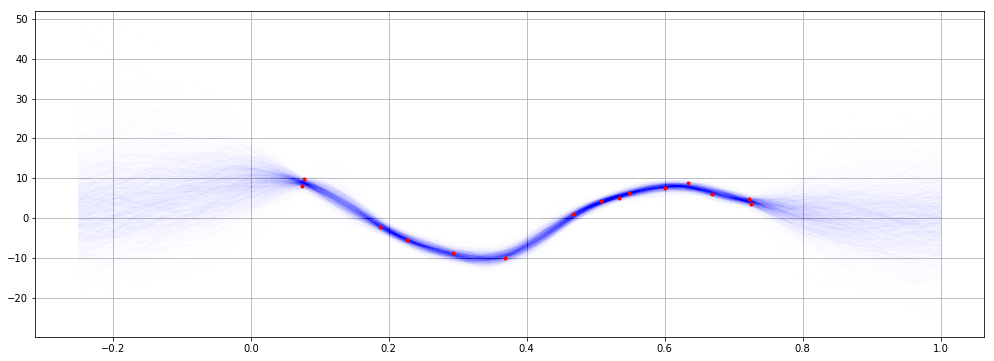

In [8]:
plt.figure(figsize=(17, 6))
for i in range(min(1000, n_samples)):
    plt.plot(X_pred.ravel(), func_samples[i], "b-", alpha=1. / 200)
plt.plot(X.ravel(), y.ravel(), "r.")
plt.grid()
plt.legend(fontsize=12)
plt.show()

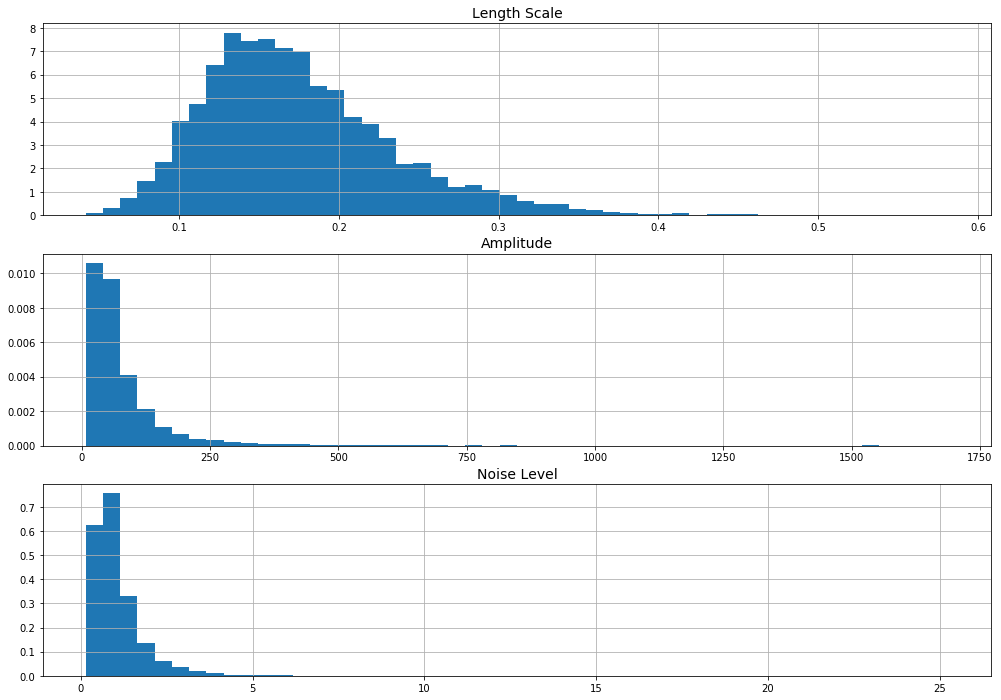

In [9]:
f, axes = plt.subplots(3, figsize=(17, 12))
for i, ax in enumerate(axes):
    ax.hist(samples[:, i], bins=50, normed=True)
    ax.grid()
    ax.set_title(["Length Scale", "Amplitude", "Noise Level"][i], fontsize=14)
plt.show()